In [1]:
import numpy as np
import energyflow
from particle import Particle

import torch
import torch.nn as nn
import pennylane as qml
from torch_geometric.nn import GCNConv
from torch.nn import Linear, ReLU, Sigmoid, ModuleList, LeakyReLU
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, L1Loss
from torch.optim import Adam
from torch_geometric.loader import DataLoader
from tqdm import tqdm

import networkx as nx
import os
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
n_connections = 8
input_dims = 8
hidden_dims = [32,16,8]
output_dims = 4
q_depth = 1
epochs = 20
lr = 1e-3
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
batch_size = 1000

In [3]:
X = np.load(r'../data/qg_graph/x10_sorted_12500.npy')
y = np.load(r'../data/qg_graph/y10_sorted_12500.npy')

In [4]:
# '''
# ------------------------------------------------------------------------------------------
#  Using graphs with a general number of nodes
# ------------------------------------------------------------------------------------------
# '''
# def preprocess_general(x_data,y_data): #,masses):
#     print('--- Finding All Unique Particles ---')
#     unique_particles = np.unique(x_data[:,:,3])
#     x_data = torch.tensor(x_data)
#     y_data = torch.tensor(y_data)
#     print()
#     print('--- Inserting Masses ---')
#     masses = torch.zeros((x_data.shape[0],x_data.shape[1]))
#     for i,particle in tqdm(enumerate(unique_particles)):
#         if particle!=0:
#             mass = Particle.from_pdgid(particle).mass/1000
#             inds = torch.where(particle==x_data[:,:,3])
#             masses[inds]=mass # GeV
#     print()
#     print('--- Calculating Momenta and Energies ---')
#     #theta = torch.arctan(torch.exp(-X[:,:,1]))*2 # polar angle
#     pt        = x_data[:,:,0]     # transverse momentum
#     rapidity  = x_data[:,:,1]     # rapidity
#     phi       = x_data[:,:,2]     # azimuthal angle
    
#     mt        = (pt**2+masses**2).sqrt() # Transverse mass
#     energy    = mt*torch.cosh(rapidity) # Energy per multiplicity bin
#     e_per_jet = energy.sum(axis=1)  # total energy per jet summed across multiplicity bins

#     px = pt*torch.cos(phi)  # momentum in x
#     py = pt*torch.sin(phi)  # momentum in y
#     pz = mt*torch.sinh(rapidity)  # momentum in z
    
#     # three momentum
#     p  = torch.cat(( px[:,:,None],  
#                      py[:,:,None],
#                      pz[:,:,None]), dim=2 )

#     p_per_jet        = (p).sum(axis=1)  # total componet momentum per jet
#     pt_per_Mbin      = (p_per_jet[:,:2]**2).sum(axis=1).sqrt()  # transverse momentum per jet
#     mass_per_jet     = (e_per_jet**2-(p_per_jet**2).sum(axis=1)).sqrt() # mass per jet
#     rapidity_per_jet = torch.log( (e_per_jet+p_per_jet[:,2])/(e_per_jet-p_per_jet[:,2]) )/2  # rapidity per jet from analytical formula
#     end_multiplicity_indx_per_jet = (pt!=0).sum(axis=1).int() # see where the jet (graph) ends
    
#     x_data = torch.cat( ( x_data[:,:,:3],
#                           x_data[:,:,4:],
#                           masses[:,:,None],
#                           energy[:,:,None],
#                           p), dim=2)
    
#     x_data_max = (x_data.max(dim=1).values).max(dim=0).values
#     x_data = x_data/x_data_max

#     print()
#     print('--- Calculating Edge Tensors ---')
#     N = x_data[:,0,3].shape[0]  # number of jets (graphs)
#     M = x_data[0,:,3].shape[0]  # number of max multiplicty
#     connections = 8
#     edge_tensor = torch.zeros((N,M,M))
#     edge_indx_tensor = torch.zeros((N,2,M*(connections+1))) # M*(connections+1) is the max number of edges we allow per jet
#     edge_attr_matrix = torch.zeros((N,M*(connections+1),1)) 
#     for jet in tqdm(range(N)):
#         stop_indx = end_multiplicity_indx_per_jet[jet] # stop finding edges once we hit zeros
#         if end_multiplicity_indx_per_jet[jet]>connections:
#             for m in range(end_multiplicity_indx_per_jet[jet]):
#                 inds_edge = np.argsort((energy[jet,m]+energy[jet,:stop_indx])**2-torch.sum((p[jet,m,:stop_indx]+p[jet,:stop_indx,:])**2,axis=1))[:connections]
#                 edge_tensor[jet,m,inds_edge] = (energy[jet,m]+energy[jet,inds_edge])**2-torch.sum((p[jet,m,:]+p[jet,inds_edge,:])**2,axis=1)
#                 edge_tensor[jet,m,m]=((energy[jet,m]+energy[jet,m])**2-torch.sum((p[jet,m,:]+p[jet,m,:])**2,axis=0))
#             edges_exist_at = torch.where(edge_tensor[jet,:,:].abs()>0)
#             edge_indx_tensor[jet,:,:(edge_tensor[jet,:,:].abs()>0).sum()] = torch.cat((edges_exist_at[0][None,:],edges_exist_at[1][None,:]),dim=0).reshape((2,edges_exist_at[0].shape[0]))   
#             edge_attr_matrix[jet,:(edge_tensor[jet,:,:].abs()>0).sum(),0]  =  edge_tensor[jet,edges_exist_at[0],edges_exist_at[1]].flatten()

#     end_edges_indx_per_jet = (edge_attr_matrix!=0).sum(axis=1).int()
#     keep_inds = np.where(end_edges_indx_per_jet!=0)[0]
    
#     edge_tensor = edge_tensor/edge_tensor.max()
#     edge_attr_matrix = edge_attr_matrix/edge_attr_matrix.max()
    

#     graph_help = torch.cat( ( (energy.max(axis=1).values/e_per_jet).reshape(x_data[:,0,3].shape[0],1),
#                               (mass_per_jet).reshape(x_data[:,0,3].shape[0],1),
#                               (end_multiplicity_indx_per_jet).reshape(x_data[:,0,3].shape[0],1).int(),
#                               (end_edges_indx_per_jet).reshape(x_data[:,0,3].shape[0],1).int() ), dim=1)
        
#     return x_data[keep_inds], y_data[keep_inds].long(), edge_tensor[keep_inds], edge_indx_tensor[keep_inds].long(), edge_attr_matrix[keep_inds], graph_help[keep_inds]

In [5]:
# x_data, y_data, edge_tensor, edge_indx_tensor, edge_attr_matrix, graph_help = preprocess_general(X,y)

In [6]:
def feature_engineer_dataset(X):
    
    # unpack all features
    pt = X[:,:,0]
    rapidity = X[:,:,1]
    phi = X[:,:,2]
    pdgids = X[:,:,3]

    # Calculate new feature values
    nonzero_pdgids = np.where(pdgids > 0) 
    mass = np.zeros(pdgids.shape)
    mass_nonzeros = np.vectorize(Particle.from_pdgid)(pdgids[nonzero_pdgids])
    mass[nonzero_pdgids] = np.fromiter((i.mass for i in mass_nonzeros), float)

    mt = np.sqrt(np.square(mass) + np.square(pt))
    energy = mass*np.cosh(rapidity) 
    px = pt*np.cos(phi)
    py = pt*np.sin(phi)
    pz = mt*np.sinh(rapidity)
    
    return torch.tensor(np.stack((pt, rapidity, phi, mt, energy, px, py, pz), axis=2), dtype=torch.float)

In [7]:
X = X[:,:n_connections,:]
X_new = feature_engineer_dataset(X)

In [8]:
torch.amax(X_new,dim=(0,1))
X_norm = X_new / torch.amax(X_new, dim=(0,1))
X_norm.shape

torch.Size([12500, 8, 8])

In [12]:
def create_graph(x):
    M = x.shape[0]  # number of nodes in graph (particles)
    N = min(M-1, n_connections-1)    # number of neighbors of each node to be considered for edge connections (1 extra for self loops) 
    # (√N is considered optimal number of neighbors for k-NN on N points)
    edge_index = torch.zeros((2,M*N))   
    edge_attr = torch.zeros((M*N, 1))
    
    for i, features in enumerate(x):
        # find N nearest neighbors in (𝜙,𝑦) space
        distances = torch.sqrt((features[2] - x[:,2])**2 + (features[1] - x[:,1])**2)
        N_nearest = np.argsort(distances)[:N]
        
        edge_index[0][i*N:(i+1)*N] = torch.tensor([i for _ in range(N)])
        edge_index[1][i*N:(i+1)*N] = N_nearest
        edge_attr[i*N:(i+1)*N] = distances[N_nearest].reshape(N,1)
     
    edge_index = edge_index.to(torch.int)
    return edge_index, edge_attr

In [13]:
def create_graph_dataset(X, y):
    dataset = []
        
    for Xi, yi in zip(X,y):

        edge_index, edge_attr = create_graph(Xi)            
        data = Data(x=Xi, edge_index=edge_index, edge_attr=edge_attr,y=torch.tensor(yi, dtype=torch.long))
        dataset.append(data)
        
    return dataset

In [14]:
dataset = create_graph_dataset(X_norm,y)
len(dataset), dataset[0]

(12500, Data(x=[8, 8], edge_index=[2, 56], edge_attr=[56, 1], y=0))

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_graph_samples(dataset, num_samples=3):
    plt.figure(figsize=(10, 5 * num_samples))
    
    for i, data in enumerate(dataset[:num_samples]):
        plt.subplot(1, num_samples, i+1)
        
        # Convert the graph to a NetworkX format
        G = to_networkx(data, to_undirected=True)
        
        # Extract node features and visualize them as node labels
        node_labels = {j: f"pt: {data.x[j][0]:.2f}, y: {data.x[j][1]:.2f}, phi: {data.x[j][2]:.2f}, mt: {data.x[j][3]:.2f}" 
                       for j in range(data.x.size(0))}
        
        # Draw the graph with node labels
        nx.draw(G, with_labels=True, labels=node_labels, node_size=200, font_size=10)
        plt.title(f"Graph {i} (Label: {data.y.item()})")
    
    plt.show()

In [16]:
# # Example usage:
# visualize_graph_samples(dataset, num_samples=3)

In [17]:
import torch
from torch_geometric.utils import subgraph

# Function to randomly drop nodes in a graph
def drop_nodes(data, drop_prob=0.2):
    node_mask = torch.rand(data.x.size(0)) > drop_prob
    data.x = data.x[node_mask]
    data.edge_index, _ = subgraph(node_mask, data.edge_index, relabel_nodes=True)
    return data

# Function to randomly drop edges in a graph
def drop_edges(data, drop_prob=0.2):
    edge_mask = torch.rand(data.edge_index.size(1)) > drop_prob
    data.edge_index = data.edge_index[:, edge_mask]
    return data

# Function to randomly mask node features in a graph
def mask_features(data, mask_prob=0.2):
    feature_mask = torch.rand(data.x.size()) > mask_prob
    data.x = data.x * feature_mask.float()
    return data

# Apply multiple augmentations
def graph_augment(data):
    aug_data = drop_nodes(data.clone())
    aug_data = drop_edges(aug_data)
    aug_data = mask_features(aug_data)
    return aug_data


In [18]:
import random
from torch_geometric.data import Data
from collections import defaultdict

# Define the augmentation function
def graph_augment(data):
    # Example augmentation: randomly drop nodes, edges, and mask features
    data_aug = data.clone()
    data_aug = drop_nodes(data_aug, drop_prob=0.1)
    # data_aug = drop_edges(data_aug, drop_prob=0.1)
    data_aug = mask_features(data_aug, mask_prob=0.1)
    return data_aug

def create_contrastive_pairs(dataset):
    pairs = []
    labels = []

    # Group graphs by their labels (0 or 1)
    label_to_graphs = defaultdict(list)
    for data in dataset:
        label_to_graphs[data.y.item()].append(data)

    # Create pairs for positive class
    for data in label_to_graphs[1]:  # For each positive graph
        data_aug = graph_augment(data)  # Create an augmented version
        pairs.append((data, data_aug))  # Add the original and augmented graph as a pair
        labels.append(1)  # Label 1 for positive pair (similar)

    # Create pairs for negative class
    for data in label_to_graphs[0]:  # For each negative graph
        data_aug = graph_augment(data)  # Create an augmented version
        pairs.append((data, data_aug))  # Add the original and augmented graph as a pair
        labels.append(0)  # Label 0 for negative pair (dissimilar)

    return pairs, labels


In [19]:
pairs, labels = create_contrastive_pairs(dataset)


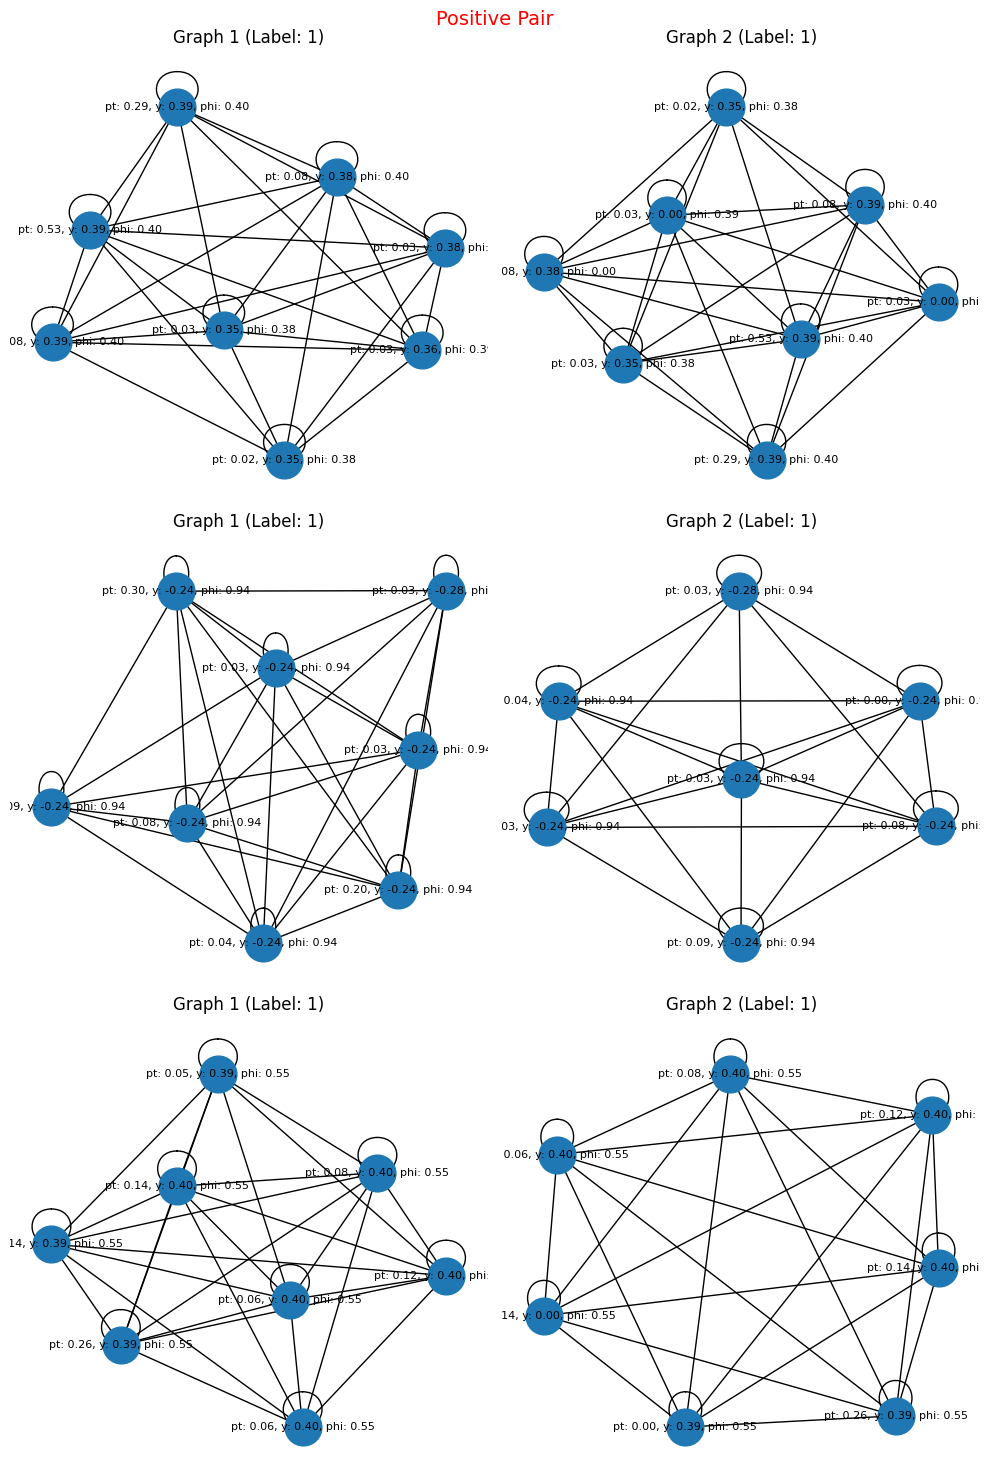

In [20]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

def visualize_graph_pairs(pairs, labels, num_pairs=3):
    plt.figure(figsize=(10, 5 * num_pairs))
    
    for i, (data1, data2) in enumerate(pairs[:num_pairs]):
        # Create a subplot for each pair
        plt.subplot(num_pairs, 2, 2 * i + 1)
        
        # Convert both graphs to NetworkX format for visualization
        G1 = to_networkx(data1, to_undirected=True)
        node_labels_1 = {j: f"pt: {data1.x[j][0]:.2f}, y: {data1.x[j][1]:.2f}, phi: {data1.x[j][2]:.2f}" 
                         for j in range(data1.x.size(0))}
        
        nx.draw(G1, with_labels=True, labels=node_labels_1, node_size=700, font_size=8)
        plt.title(f"Graph 1 (Label: {data1.y.item()})")

        plt.subplot(num_pairs, 2, 2 * i + 2)
        G2 = to_networkx(data2, to_undirected=True)
        node_labels_2 = {j: f"pt: {data2.x[j][0]:.2f}, y: {data2.x[j][1]:.2f}, phi: {data2.x[j][2]:.2f}" 
                         for j in range(data2.x.size(0))}
        
        nx.draw(G2, with_labels=True, labels=node_labels_2, node_size=700, font_size=8)
        plt.title(f"Graph 2 (Label: {data2.y.item()})")

        pair_type = "Positive Pair" if labels[i] == 1 else "Negative Pair"
        plt.suptitle(pair_type, fontsize=14, color='red')

    plt.tight_layout()
    plt.show()

# Example usage:
visualize_graph_pairs(pairs, labels, num_pairs=3)


In [21]:
from torch.utils.data import Dataset

class GraphPairDataset(Dataset):
    def __init__(self, pairs, labels):
        self.pairs = pairs  # List of (graph1, graph2) tuples
        self.labels = labels  # List of similarity labels (0 or 1)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        graph1, graph2 = self.pairs[idx]
        label = self.labels[idx]
        return graph1, graph2, label


In [22]:
import torch
from sklearn.model_selection import train_test_split

def split_pairs(pairs, labels, train_ratio, val_ratio):
    # Split train and temporary (val + test)
    train_pairs, temp_pairs, train_labels, temp_labels = train_test_split(
        pairs, labels, train_size=train_ratio, random_state=42, stratify=labels
    )
    
    # Split validation and test from the temporary set
    val_pairs, test_pairs, val_labels, test_labels = train_test_split(
        temp_pairs, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
    )
    
    return train_pairs, train_labels, val_pairs, val_labels, test_pairs, test_labels

# Assuming pairs and labels are created using create_contrastive_pairs()
# pairs, labels = create_contrastive_pairs(dataset)  # Create pairs for the entire dataset

# Define the split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Split the pairs into training, validation, and test sets
train_pairs, train_labels, val_pairs, val_labels, test_pairs, test_labels = split_pairs(
    pairs, labels, train_ratio, val_ratio
)

In [23]:
# Now, create datasets and dataloaders for each split
train_dataset = GraphPairDataset(train_pairs, train_labels)
val_dataset = GraphPairDataset(val_pairs, val_labels)
test_dataset = GraphPairDataset(test_pairs, test_labels)

batch_size = 1000

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [24]:
train_dataset[0][0].edge_index

tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
         3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
         6, 7, 7, 7, 7, 7, 7, 7],
        [0, 2, 5, 1, 4, 3, 6, 1, 5, 2, 0, 4, 3, 6, 2, 0, 5, 1, 4, 3, 6, 3, 4, 6,
         7, 1, 5, 2, 4, 3, 6, 7, 1, 5, 2, 5, 2, 0, 1, 4, 3, 6, 6, 7, 4, 3, 1, 5,
         2, 7, 6, 3, 4, 1, 5, 2]], dtype=torch.int32)

In [25]:
train_dataset[0][1].edge_index

tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
         3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
         6, 7, 7, 7, 7, 7, 7, 7],
        [0, 2, 5, 1, 4, 3, 6, 1, 5, 2, 0, 4, 3, 6, 2, 0, 5, 1, 4, 3, 6, 3, 4, 6,
         7, 1, 5, 2, 4, 3, 6, 7, 1, 5, 2, 5, 2, 0, 1, 4, 3, 6, 6, 7, 4, 3, 1, 5,
         2, 7, 6, 3, 4, 1, 5, 2]], dtype=torch.int32)

In [26]:
train_dataset[0]

(Data(x=[8, 8], edge_index=[2, 56], edge_attr=[56, 1], y=1),
 Data(x=[8, 8], edge_index=[2, 56], edge_attr=[56, 1], y=1),
 1)

In [27]:


# Check a sample from the dataloader
for data1, data2, label in train_dataloader:
    print(data1)
    print(data2)
    print(label)
    break


DataBatch(x=[8000, 8], edge_index=[2, 56000], edge_attr=[56000, 1], y=[1000], batch=[8000], ptr=[1001])
DataBatch(x=[7220, 8], edge_index=[2, 46349], edge_attr=[56000, 1], y=[1000], batch=[7220], ptr=[1001])
tensor([0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
        0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
        1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1

In [28]:
from torch_geometric.nn import GATConv, global_mean_pool, GraphConv
from torch.nn import ModuleList, Linear, ReLU
import torch


class GNN(torch.nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims, activ_fn):
        super().__init__()
        layers = []
        layers.append(GATConv(input_dims, hidden_dims[0]))
    
        for i in range(len(hidden_dims)-1):
            layers.append(GATConv(hidden_dims[i], hidden_dims[i+1]))
            
        self.layers = ModuleList(layers)
        self.activ_fn = activ_fn
        self.readout_layer = Linear(hidden_dims[-1], output_dims)  # No final classifier, just embeddings
        self.dropout = torch.nn.Dropout(p=0.5)  # Add dropout to layers


    def forward(self, x, edge_index, batch):
        h = x
        for i in range(len(self.layers)):
            h = self.layers[i](h, edge_index)
            h = self.activ_fn(h)
            h = self.dropout(h)  # Apply dropout
         
        h = global_mean_pool(h, batch)   # Readout layer to get the embedding for each graph in batch
        return h  # Return the graph embeddings


In [29]:
def run_model(model, epoch, dataloader, lossFn, optimizer=None, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0
    correct = 0
    num_samples = 0

    for batch in dataloader:
        optimizer.zero_grad() if train else None

        # Extract the pairs and labels from the dataloader batch
        data1, data2, labels = batch[0], batch[1], batch[2]
        
        # Get the embeddings for both graphs
        emb1 = model(data1.x, data1.edge_index, data1.batch)
        emb2 = model(data2.x, data2.edge_index, data2.batch)
        
        # Compute contrastive loss
        loss = lossFn(emb1, emb2)  # Now the labels are passed explicitly
        
        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * data1.num_graphs
        num_samples += data1.num_graphs

        # Compute accuracy
        with torch.no_grad():
            cos_sim = torch.nn.functional.cosine_similarity(emb1, emb2)
            predictions = (cos_sim > 0.5).long()  # You can adjust the threshold
            # correct = (predictions == labels.to(self.device)).sum().item()
            correct += (predictions == labels).sum().item()
            total = labels.size(0)

    avg_loss = total_loss / num_samples
    accuracy = correct / num_samples
    return avg_loss, accuracy


In [30]:
def train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader):
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        # Run training
        train_loss, train_acc = run_model(model, epoch, train_dataloader, lossFn, optimizer)
        
        # Run validation
        val_loss, val_acc = run_model(model, epoch, val_dataloader, lossFn, optimizer=None, train=False)
        
        # Print results
        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        # Store loss and accuracy for this epoch
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
    return history


In [33]:
os.chdir('..');
print(os.getcwd())
from qssl.loss.losses import ContrastiveLoss

C:\Users\Sanya Nanda\Sanya-Home\gsoc2024\ML4Sci_QuantumContrastiveLearning


In [34]:
model = GNN(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lossFn = ContrastiveLoss(margin=1, mode='pairs')  # Use contrastive loss in pair mode
history = train_model(model, optimizer, lossFn=lossFn, epochs=50, lr=0.001, train_dataloader=train_dataloader, val_dataloader=val_dataloader)


Epoch 1, Train Loss: 0.9280, Val Loss: 0.9490, Train Acc: 0.4973, Val Acc: 0.4981
Epoch 2, Train Loss: 0.8462, Val Loss: 0.9032, Train Acc: 0.4967, Val Acc: 0.4976
Epoch 3, Train Loss: 0.7150, Val Loss: 0.8218, Train Acc: 0.4937, Val Acc: 0.4976
Epoch 4, Train Loss: 0.5372, Val Loss: 0.7000, Train Acc: 0.4973, Val Acc: 0.4981
Epoch 5, Train Loss: 0.3436, Val Loss: 0.5704, Train Acc: 0.4975, Val Acc: 0.4981
Epoch 6, Train Loss: 0.2044, Val Loss: 0.4654, Train Acc: 0.4958, Val Acc: 0.4981
Epoch 7, Train Loss: 0.1186, Val Loss: 0.4013, Train Acc: 0.4954, Val Acc: 0.4981
Epoch 8, Train Loss: 0.0711, Val Loss: 0.3649, Train Acc: 0.4983, Val Acc: 0.4981
Epoch 9, Train Loss: 0.0448, Val Loss: 0.3435, Train Acc: 0.4985, Val Acc: 0.4981
Epoch 10, Train Loss: 0.0306, Val Loss: 0.3299, Train Acc: 0.4983, Val Acc: 0.4981
Epoch 11, Train Loss: 0.0228, Val Loss: 0.3204, Train Acc: 0.4974, Val Acc: 0.4981
Epoch 12, Train Loss: 0.0182, Val Loss: 0.3133, Train Acc: 0.4974, Val Acc: 0.4981
Epoch 13, Tra

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_auc(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_scores = []

    with torch.no_grad():
        for data1, data2, labels in dataloader:
            emb1 = model(data1.x, data1.edge_index, data1.batch)
            emb2 = model(data2.x, data2.edge_index, data2.batch)
            distances = torch.sqrt(torch.sum((emb1 - emb2) ** 2, dim=1)).cpu().numpy()  # L2 distance
            cos_sim = torch.nn.functional.cosine_similarity(emb1, emb2)
            # predictions = (cos_sim > 0.5).long()
            y_scores.extend(cos_sim)
            y_true.extend(labels.cpu().numpy())

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot AUC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


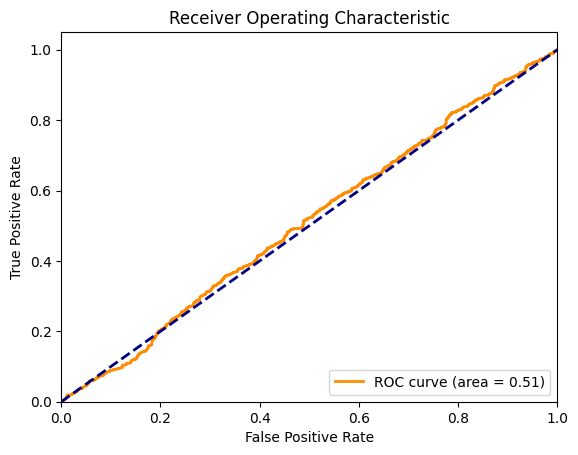

In [38]:
plot_auc(model, test_dataloader)


In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data1, data2, labels in dataloader:
            emb1 = model(data1.x, data1.edge_index, data1.batch)
            emb2 = model(data2.x, data2.edge_index, data2.batch)
            # distances = torch.sqrt(torch.sum((emb1 - emb2) ** 2, dim=1))  # L2 distance
            # predictions = (distances < 0.5).cpu().numpy()  # Threshold of 0.5 for similarity

            cos_sim = torch.nn.functional.cosine_similarity(emb1, emb2)
            predictions = (cos_sim > 0.5).long()
            
            y_pred.extend(predictions)
            y_true.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Dissimilar", "Similar"])
    
    # Plot confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()


In [ ]:
from sklearn.manifold import TSNE

def plot_embeddings(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    embeddings = []
    labels = []

    with torch.no_grad():
        for data1, data2, label in dataloader:
            emb1 = model(data1.x, data1.edge_index, data1.batch)
            emb2 = model(data2.x, data2.edge_index, data2.batch)
            embeddings.extend(emb1.cpu().numpy())
            embeddings.extend(emb2.cpu().numpy())
            labels.extend(label.cpu().numpy())
            labels.extend(label.cpu().numpy())  # Add labels for both graphs in the pair

    # Reduce dimensions for visualization (e.g., t-SNE)
    embeddings_2d = TSNE(n_components=2).fit_transform(embeddings)
    
    # Plot embeddings
    plt.figure(figsize=(8, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='coolwarm', s=10)
    plt.title("Graph Embeddings (t-SNE)")
    plt.colorbar()
    plt.show()


In [ ]:
def print_pair_embeddings(model, dataloader, pair_index=0):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        data1, data2, label = next(iter(dataloader))
        emb1 = model(data1.x, data1.edge_index, data1.batch)
        emb2 = model(data2.x, data2.edge_index, data2.batch)
        
        print(f"Embeddings for pair {pair_index}:")
        print("Embedding 1:", emb1)
        print("Embedding 2:", emb2)
        print("Label:", label)


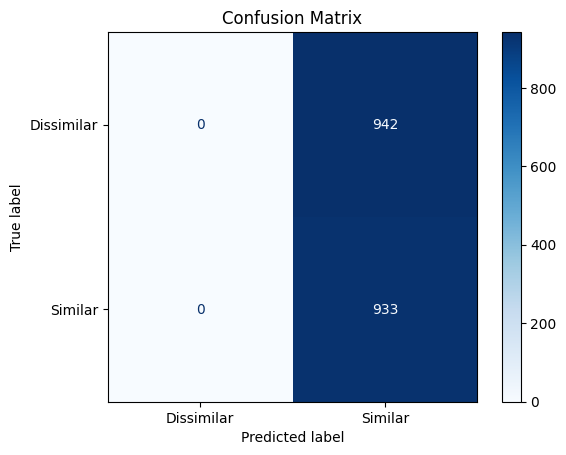

In [40]:
plot_confusion_matrix(model, test_dataloader)


In [ ]:
print_pair_embeddings(model, test_dataloader, pair_index=45)